In [1]:
from shapely.geometry import mapping, Polygon
import fiona

# You can see a schema as column names and types of a table which holds all the data (see bellow)

schema = {
    'geometry': 'Polygon',
    'properties': {'id': 'int'},
}

# Here are polygons which define our map

class maison():
    shape = None
    shadow = None

    def __init__(self,shape,shadow):
        self.shape = shape #shape
        self.shadow = shadow
    
    '''
    write in a json file the shapes of house
    '''
    def export_json(self, filename):
        with fiona.open(filename, 'w', 'GeoJSON', schema) as c:
            c.write({
                'geometry': mapping(self.shadow),
                'properties': {'id': 1},
            })
            c.write({
                'geometry': mapping(self.shape),
                'properties': {'id': 2},
            })
        return filename

poly2 = Polygon([(1, 1),(4,1), (4,4), (1,4)]) #shadow
poly1 = Polygon([(1, 1.2),(3.9,1.2), (3.9,4), (1,4)]) #shape
maison1 = maison(poly1,poly2)
print(maison1.export_json("/tmp/my_shp2.json"))

/tmp/my_shp2.json


In [2]:
!cat /tmp/my_shp2.json

{
"type": "FeatureCollection",
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1.0, 1.0 ], [ 4.0, 1.0 ], [ 4.0, 4.0 ], [ 1.0, 4.0 ], [ 1.0, 1.0 ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 1.0, 1.2 ], [ 3.9, 1.2 ], [ 3.9, 4.0 ], [ 1.0, 4.0 ], [ 1.0, 1.2 ] ] ] } }
]
}


In [3]:
import json

with open('/tmp/my_shp2.json') as f:
    data = json.load(f)
    
data

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'id': 1},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[1.0, 1.0],
      [4.0, 1.0],
      [4.0, 4.0],
      [1.0, 4.0],
      [1.0, 1.0]]]}},
  {'type': 'Feature',
   'properties': {'id': 2},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[1.0, 1.2],
      [3.9, 1.2],
      [3.9, 4.0],
      [1.0, 4.0],
      [1.0, 1.2]]]}}]}

<AxesSubplot:>

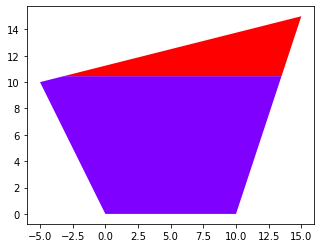

In [4]:
import geopandas as gpd

shapes = gpd.read_file('/tmp/house_class.json')
shapes.plot(cmap="rainbow")   # arg column is used to define colors, cmap maps column values to colors

(-50.0, 0.0, 150.0, 150.0)


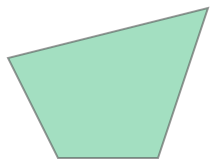

In [5]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import mapping, Polygon, Point, LineString, MultiPolygon
import numpy as np


poly = Polygon([(0,0), (100,0), (150,150), (-50,100)])
print(poly.bounds)
poly

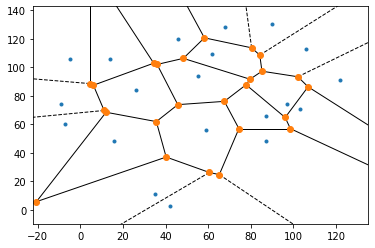

In [39]:
import random as r
import matplotlib.pylab as plt
HOUSES_MAX = 20
def partition(poly):
    (min_x,min_y,max_x,max_y) = poly.bounds
    nb = 0
    points = []
    while(nb < HOUSES_MAX):
        x = r.randint(min_x, max_x)
        y = r.randint(min_y, max_y)
        if (poly.contains(Point(x,y))):
            points.append((x,y))
            nb+=1
    return points

points = partition(poly)
vor = Voronoi(points)
voronoi_plot_2d(vor);

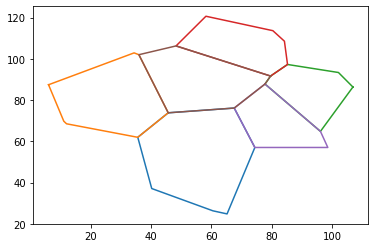

In [40]:
def get_sub_parts(vor, poly):
    regions = [r for r in vor.regions if -1 not in r and len(r) > 0]
    regions = [Polygon([vor.vertices[i] for i in r]) for r in regions]
    return [r for r in regions if poly.contains(r) ]

for r in get_sub_parts(vor, poly)[0:12]:
    plt.plot(*r.exterior.xy)

In [8]:
open("/tmp/house_class.json")

<_io.TextIOWrapper name='/tmp/house_class.json' mode='r' encoding='UTF-8'>

In [9]:
from house import *
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import mapping, Polygon, Point, LineString, MultiPolygon
import numpy as np
import random as r


HOUSES_MAX = 40

def _partition_polygon(poly):
        (min_x,min_y,max_x,max_y) = poly.bounds
        nb = 0
        points = []
        while(nb < HOUSES_MAX):
            x = r.randint(min_x, max_x)
            y = r.randint(min_y, max_y)
            if (poly.contains(Point(x,y))):
                points.append((x,y))
                nb+=1
        return points

def _get_sub_region(vor, poly):
    regions = [r for r in vor.regions if -1 not in r and len(r) > 0]
    regions = [Polygon([vor.vertices[i] for i in r]) for r in regions]
    return [r for r in regions if poly.contains(r) ]


class Block():

    #private:
    _polygon = None
    _house_list = []



    def __init__(self,polygon):
        self._polygon = polygon
        self.house_partition() # Réparti la liste des maisons en fonction du polygone

    def house_partition(self):
        points = _partition_polygon(self._polygon)
        vor = Voronoi(points)
        regions = _get_sub_region(vor,self._polygon)

        #Pour le moment toutes les maisons ont un jardin
        self._house_list = [House(region, False, 180) for region in regions]


    def components(self):
        if len(self._house_list) > 0:
            return [house.components() for house in self._house_list]
        else:
            return []




if __name__ == "__main__":
    from shapely.geometry import mapping, Polygon, Point, LineString, MultiPolygon
    import json

    shape = Polygon([(0,0), (400,0), (150,150), (-50,100)])
    block = Block(shape)
    print(block.components())
    tools.json(block, '/tmp/block.json')

[Category.HOUSE:POLYGON ((45.77340267459138 67.92496285289748, 43.09706546275395 58.00677200902935, 41.72727272727273 56.5, -7.100000000000001 56.5, -15.86448598130841 63.13976210705182, 11.15197215777262 86.47215777262181, 45.77340267459138 67.92496285289748)), Category.HOUSE:POLYGON ((268.0459088069956 23.710493441599, 258.1064516129032 59.32688172043011, 216.9857142857143 29.62857142857143, 265.2709251101322 17.55726872246696, 268.0459088069956 23.710493441599)), Category.HOUSE:POLYGON ((205.3467374810319 69.14339908952959, 184.9983314794216 73.61012235817574, 167.1271721958926 105.522906793049, 167.6690909090909 106.44, 177.1339285714286 111.9196428571429, 208.0958904109589 93.34246575342466, 212.2758620689655 75.57758620689656, 205.3467374810319 69.14339908952959)), Category.HOUSE:POLYGON ((167.1271721958926 105.522906793049, 133.6855333060891 89.63812832039231, 138.7440543601359 68.23669309173273, 165.3618421052632 61.97368421052632, 184.9983314794216 73.61012235817574, 167.12717

In [20]:
from block import *
from field import *
from lake  import *
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import mapping, Polygon, Point, LineString, MultiPolygon
import numpy as np
import random as r


SUB_BLOCK_MAX =  20

def _partition_polygon0(poly):
        (min_x,min_y,max_x,max_y) = poly.bounds
        nb = 0
        points = []
        while(nb < HOUSES_MAX):
            x = r.randint(min_x, max_x)
            y = r.randint(min_y, max_y)
            if (poly.contains(Point(x,y))):
                points.append((x,y))
                nb+=1
        return points

def _get_sub_region0(vor, poly):
    regions = [r for r in vor.regions if -1 not in r and len(r) > 0]
    regions = [Polygon([vor.vertices[i] for i in r]) for r in regions]
    return [r for r in regions if poly.contains(r) ]


class District():

    #private:
    _polygon = None
    _blocks_list = []
    _lake_list   = []
    _field_list  = []

    def __init__(self,polygon):
        self._polygon = polygon
        self.block_partition()

    def block_partition(self):
        points = _partition_polygon0(self._polygon)
        print(points)
        vor = Voronoi(points)
        regions = _get_sub_region0(vor,self._polygon)

        #remplir les listes des différents types de blocks
        #lac: 1 lac une fois sur 3
        #field: 1/3 de champs
        #block: reste

        nb_regions = len(regions)
        already_a_lake = False
        already_enough_fields = False

        for region in regions:
            if not already_a_lake and r.randint(0,3 * nb_regions) == 0:
                self._lake_list.append(Lake(region))
                already_a_lake = True

            elif not already_enough_fields and r.randint(0,nb_regions//3) == 0:
                self._field_list.append(Field(region))
                if (len(_field_list) >= nb_regions//3):
                    already_enough_fields = True
            else:
                self._blocks_list.append(Block(region))

    def components(self):
        if len(self._blocks_list) > 0:
            return [block.components() for block in self._blocks_list + self._field_list + self._lake_list ]
        else:
            return []




if __name__ == "__main__":
    from shapely.geometry import mapping, Polygon, Point, LineString, MultiPolygon
    import json

    shape = Polygon([(0,0), (400,0), (150,150), (-50,100)])
    district = District(shape)
    tools.json(district, '/tmp/district.json')

[(141, 7), (115, 25), (139, 128), (-5, 14), (48, 12), (153, 29), (273, 63), (377, 4), (118, 45), (174, 108), (108, 116), (116, 127), (250, 32), (-1, 93), (172, 105), (270, 22), (226, 43), (263, 54), (254, 59), (72, 9), (330, 23), (146, 19), (209, 9), (54, 65), (196, 95), (241, 79), (144, 80), (22, 114), (206, 51), (290, 40), (182, 104), (369, 18), (240, 88), (191, 117), (55, 23), (100, 91), (14, 78), (347, 16), (-8, 65), (273, 22)]


ValueError: non-integer arg 1 for randrange()

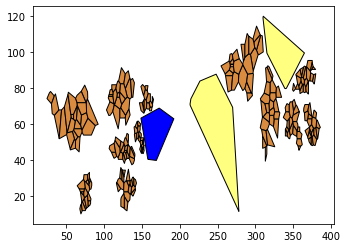

In [34]:
import matplotlib.pylab as plt
from matplotlib.colors import ListedColormap
import geopandas as gpd
import sys

filename = '/tmp/district.json'

colors_dic = {1:[0.9,0.9,0.2, 1],
              2:[1, 1, 0.5, 1],
              3:[0.25, 0.6, 0.25, 1],
              4:[0.25, 0.75, 0.9, 1],
              5:[0,0,1,1],
              8:[0.8, 0.9, 0.55, 1],
              10:[0.85, 0.55, 0.25, 1],
              11:[0.95, 0.9, 0.8, 1],
              12:[0.85, 0.5, 0.85, 1],
              31:[0.4, 0.4, 0.4, 1],
              32:[0.6, 0.6, 0.6, 1],
              33:[0.2, 0.2, 0.2, 1],
              }
colors = [[1,0,0,1] for _ in range(max(colors_dic.keys())+1)]
for i in colors_dic:
    colors[i] = colors_dic[i]
color_map = ListedColormap(colors, name='Archi')

shapes = gpd.read_file(filename)
shapes.plot(column='category', cmap=color_map,
            k=len(colors)+1, vmin=0, vmax=len(colors),
            edgecolor='black')
plt.show()